# MAIN PROJECT NOTEBOOK

Anm. "Ein einzelnes Notebook soll eure Analyse und die Darstellung der Ergebnisse darstellen."

Environment für dieses Notebook: `ads-ml-full` (*requirements-py3.11-ads-ml-full.txt*).


## Daten einlesen

In [459]:
from pathlib import Path

URL = (
    "https://data.milwaukee.gov/dataset/7a8b81f6-d750-4f62-aee8-30ffce1c64ce/resource/f083631f-e34e-4ad6-aba1-d6d7dd265170/download/2002-2018-property-sales-data.csv"
)
data = Path("/Users/knaflhei/Documents/DBUSA/data/subset_wohnraum_final_clean.csv")

In [460]:
import pandas as pd

data = pd.read_csv("/Users/knaflhei/Documents/DBUSA/data/subset_wohnraum_final_clean.csv") 
data.head(10)

,PropType,District,Style,Year_Built,Fin_sqft,Fbath,Lotsize,Sale_date,Sale_price,Fläche_pro_Bad,Immobilien_Alter,Premium,Nbhd_updated
0,Residential,1,Cape Cod,1951,1620.0,2,7800.0,2003-12,148500,3900.0,73,0,Andere
1,Residential,13,Ranch,1956,986.0,1,10428.0,2003-12,105000,10428.0,68,0,Andere
2,Residential,9,Colonial,2007,2237.0,2,11129.0,2007-08,257000,5564.5,17,0,Andere
3,Residential,1,Colonial,2004,1470.0,2,5945.0,2009-01,107500,2972.5,20,0,Andere
4,Residential,2,Cape Cod,1954,1456.0,1,5590.0,2009-01,120900,5590.0,70,0,Andere
5,Residential,2,Ranch,1966,1379.0,1,8190.0,2009-01,129900,8190.0,58,0,Andere
6,Residential,2,Ranch,1962,1361.0,1,5750.0,2009-01,126500,5750.0,62,0,Andere
7,Residential,2,Ranch,1964,1334.0,1,5544.0,2009-01,109000,5544.0,60,0,Andere
8,Residential,2,Ranch,1962,1334.0,1,5250.0,2009-01,108000,5250.0,62,0,Andere
9,Residential,2,Ranch,1959,1288.0,2,5400.0,2009-01,115000,2700.0,65,0,Andere


In [461]:
from sklearn import set_config

set_config(transform_output="pandas")

## Trainings- und Testdaten

In [462]:
unlabeled = data[data["Sale_price"].isna()].copy()
labeled = data[data["Sale_price"].notna()].copy()

In [464]:
labeled.shape

(9192, 13)

In [465]:
from sklearn.model_selection import train_test_split

y = "Sale_price"
X = data.columns.to_list()
X.remove(y)
train_data, test_data = train_test_split(
    labeled,
    test_size=0.2,
    random_state=42,
    stratify=labeled["Year_Built"],
)

### Pipeline und Modellauswahl 

In [467]:
num_cols_6 = [
    "Lotsize", 
    "Fbath",
    "Fin_sqft",
    "Fläche_pro_Bad",
    "Immobilien_Alter", 
   
]

cat_cols_6 = [
    "PropType",
    "District",
    "Style",
    "Year_Built",
    "Nbhd_updated",
    "Premium",
]
cols_set_6 = [*num_cols_6, *cat_cols_6]



In [468]:
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

ct_6a = ColumnTransformer(
    transformers=[
        ("imp", IterativeImputer(random_state=42), num_cols_6),
    ],
    remainder="passthrough",
)

In [469]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

ct_6b = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), ["imp__" + c for c in num_cols_6]),
        (
            "ohe",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            ["remainder__" + c for c in cat_cols_6],
        ),
    ],
)

In [470]:
from sklearn.pipeline import Pipeline

prep_6 = Pipeline(
    steps=[
        ("prep_a", ct_6a),
        ("prep_b", ct_6b),
    ]
)

In [471]:
from sklearn.ensemble import GradientBoostingRegressor

est_6 = GradientBoostingRegressor(random_state=42, subsample=0.6, min_samples_split=100)

In [472]:
pipeline_6 = Pipeline(steps=[("prep", prep_6), ("model", est_6)])

In [473]:
pipeline_6

Pipeline(steps=[('prep',
                 Pipeline(steps=[('prep_a',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imp',
                                                                   IterativeImputer(random_state=42),
                                                                   ['Lotsize',
                                                                    'Fbath',
                                                                    'Fin_sqft',
                                                                    'Fläche_pro_Bad',
                                                                    'Immobilien_Alter'])])),
                                 ('prep_b',
                                  ColumnTransformer(transformers=[('scale',
                                                                   StandardScaler(),
                                                                   ['imp__Lotsize',
                                                                    'imp__Fbath',
                                                                    'imp__Fin_sqft',
                                                                    'imp__Fläche_pro_Bad',
                                                                    'imp__Immobilien_Alter']),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['remainder__PropType',
                                                                    'remainder__District',
                                                                    'remainder__Style',
                                                                    'remainder__Year_Built',
                                                                    'remainder__Nbhd_updated',
                                                                    'remainder__Premium'])]))])),
                ('model',
                 GradientBoostingRegressor(min_samples_split=100,
                                           random_state=42, subsample=0.6))])

In [474]:
import os

import mlflow
from dotenv import load_dotenv

load_dotenv()

mlflow.set_tracking_uri(os.getenv("LOCAL_MLFLOW_TRACKING_URI"))  # "sqlite:///mlflow.db"
mlflow.set_experiment("4F-e2e-part5")
mlflow.sklearn.autolog(log_models=False, log_datasets=False, silent=True)

In [475]:
%%time
pipeline_6.fit(train_data[cols_set_6], train_data[y])

CPU times: user 1.41 s, sys: 94.9 ms, total: 1.51 s
Wall time: 1.13 s


Pipeline(steps=[('prep',
                 Pipeline(steps=[('prep_a',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('imp',
                                                                   IterativeImputer(random_state=42),
                                                                   ['Lotsize',
                                                                    'Fbath',
                                                                    'Fin_sqft',
                                                                    'Fläche_pro_Bad',
                                                                    'Immobilien_Alter'])])),
                                 ('prep_b',
                                  ColumnTransformer(transformers=[('scale',
                                                                   StandardScaler(),
                                                                   ['imp__Lotsize',
                                                                    'imp__Fbath',
                                                                    'imp__Fin_sqft',
                                                                    'imp__Fläche_pro_Bad',
                                                                    'imp__Immobilien_Alter']),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['remainder__PropType',
                                                                    'remainder__District',
                                                                    'remainder__Style',
                                                                    'remainder__Year_Built',
                                                                    'remainder__Nbhd_updated',
                                                                    'remainder__Premium'])]))])),
                ('model',
                 GradientBoostingRegressor(min_samples_split=100,
                                           random_state=42, subsample=0.6))])

## Performance
### R-squared (Bestimmtheitsmaß)

In [476]:
%%time
from sklearn.model_selection import cross_val_score

transformed_6 = pipeline_6[:-1].transform(train_data[cols_set_6])

cross_val_score(estimator=pipeline_6[-1], X=transformed_6, y=train_data[y], cv=3, n_jobs=3)

CPU times: user 65.7 ms, sys: 51.4 ms, total: 117 ms
Wall time: 2.79 s


array([0.6710225 , 0.64118394, 0.64146363])

In [477]:
from sklearn.metrics import r2_score

r2_score(y_true=test_data[y], y_pred=pipeline_6.predict(test_data[X]))

0.592817024434418

R-squared ist die Default Metrik für den Estimator.

In [478]:
pipeline_6.score(X=test_data[X], y=test_data[y])

0.592817024434418

### Mean Absolute Error

In [479]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=test_data[y], y_pred=pipeline_6.predict(test_data[X]))

19766.14692271468

### Root Mean Squared Error

Scikit-learn implementiert nur den MSE, davon nehmen wir die Wurzel.

In [480]:
import numpy as np
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_true=test_data[y], y_pred=pipeline_6.predict(test_data[X])))

31332.654570464543

## Explainable AI mit SHAP-Values

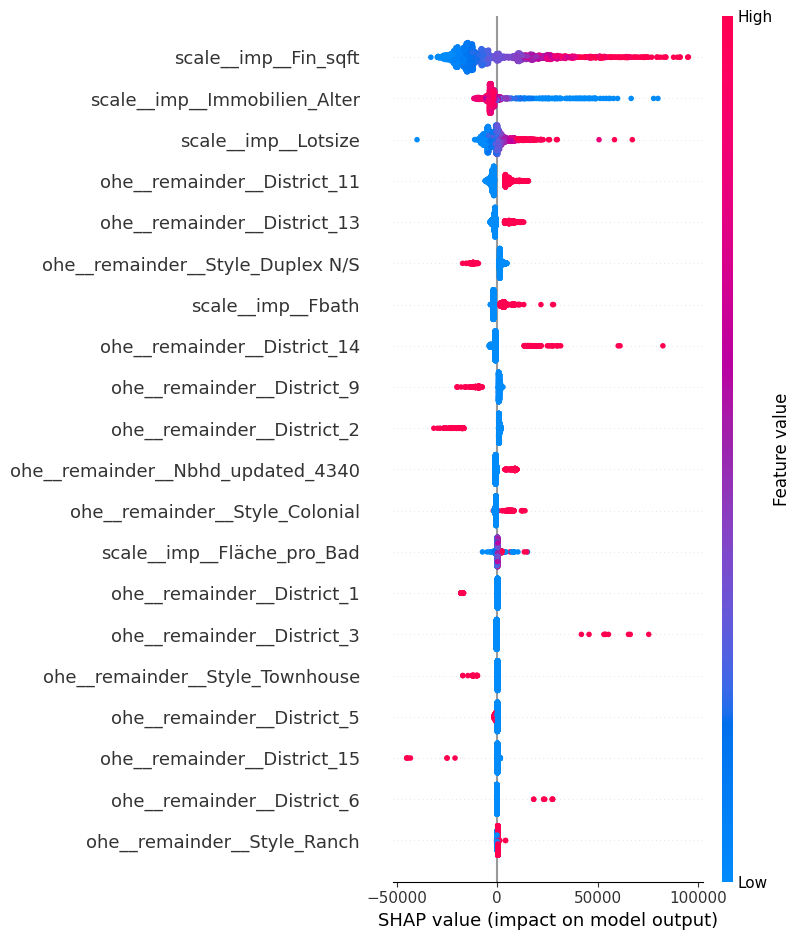

In [481]:
import shap

transformed_test_6 = pipeline_6[:-1].transform(test_data[cols_set_6])

explainer_6 = shap.TreeExplainer(pipeline_6.named_steps["model"])
shap_values_test_6 = explainer_6.shap_values(transformed_test_6)
shap.summary_plot(
    shap_values=shap_values_test_6,
    features=transformed_test_6,
    feature_names=pipeline_6[:-1].get_feature_names_out(),
)

## Model Comparison

In [482]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lars, BayesianRidge
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [484]:
models = [
    ("LinearRegression", LinearRegression()),
    ("DecisionTree", DecisionTreeRegressor()),
    ("RandomForest", RandomForestRegressor(n_estimators=100)),
    ("Lars", Lars(random_state=42)),
    ("ElasticNet", ElasticNet(random_state=42)),
    ("BayesianRidge", BayesianRidge()),
    ("MLPregressor", MLPRegressor(hidden_layer_sizes=(30, 30), random_state=42)),
]

In [485]:
%%time
from sklearn.model_selection import cross_val_score

for model in models:
    pipeline = Pipeline(steps=[("prep", prep_6), (model[0], model[1])])
    pipeline.fit(X=train_data[cols_set_6], y=train_data[y])
    cv = cross_val_score(
        estimator=pipeline[-1],
        X=pipeline[:-1].transform(train_data[cols_set_6]),
        y=train_data[y],
        cv=3,
        n_jobs=3,
    )
    print("\nEVALUATING", model[0])
    print("Cross validation", cv)
    print("Performance on test data")
    print("R2:", pipeline.score(X=test_data[cols_set_6], y=test_data[y]))
    print("MAE:", mean_absolute_error(y_true=test_data[y], y_pred=pipeline.predict(test_data[X])))


EVALUATING LinearRegression
Cross validation [-1.99663872e+19 -2.00827703e+17 -1.55673532e+20]
Performance on test data
R2: -6.000967372362879e+16
MAE: 396677139618.69604

EVALUATING DecisionTree
Cross validation [0.36465499 0.31889393 0.32386   ]
Performance on test data
R2: 0.3908463714208005
MAE: 23766.676143867007

EVALUATING RandomForest
Cross validation [0.66947512 0.63264847 0.63700767]
Performance on test data
R2: 0.5761045740978616
MAE: 18841.777291549246


/Applications/anaconda3/envs/ads-ml-full/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 134 iterations, i.e. alpha=1.983e+02, with an active set of 110 regressors, and the smallest cholesky pivot element being 9.483e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Applications/anaconda3/envs/ads-ml-full/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 139 iterations, i.e. alpha=3.709e+03, with an active set of 111 regressors, and the smallest cholesky pivot element being 9.541e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Applications/anaconda3/envs/ads-ml-full/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 139 iterations, i.e. 


EVALUATING Lars
Cross validation [-1.50993299e+31 -1.25614007e+29 -4.07366739e+31]
Performance on test data
R2: -1.1808299378147214e+34
MAE: 1.759625292631783e+20

EVALUATING ElasticNet
Cross validation [0.45600161 0.44896929 0.44222979]
Performance on test data
R2: 0.38639609004012365
MAE: 24065.139420673495

EVALUATING BayesianRidge
Cross validation [0.63870332 0.63851045 0.64020854]
Performance on test data
R2: 0.5331124312259368
MAE: 20509.263352217302


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



EVALUATING MLPregressor
Cross validation [0.57881696 0.56959114 0.55739632]
Performance on test data
R2: 0.5103353317225918
MAE: 20421.25185251333
CPU times: user 25.4 s, sys: 3.73 s, total: 29.1 s
Wall time: 20.7 s


/Applications/anaconda3/envs/ads-ml-full/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/ads-ml-full/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/ads-ml-full/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Interpretation 

Der Random Forest Regressor ist in der finalen Versuchsanordnung, bei der alle final im Datensatz "subset_wohnraum_final_clear" ausgewählten Features unter Berücksichitgung von ChatGPT erstellten zusätzlichen Features als Colum-Set 6 gleichermaßen beim Modelltraining berücksichtigt wurden, das Modell mit der besten Performance bei der Vorhersage von Preisen der Immobilien in Milwaukee. Allerdings, jedoch zeigt der Gradient Boosting Regressor - wie auch in den meisten vorangegangenen iterativen Versuchen mit unterschiedlichen anderen Feature-Sests – eine ähnlich starke Leistung, insbesondere in Bezug auf die R2-Werte auf den Testdaten, was ihn zu einer hervorragenden Alternative macht. Die BayesianRidge- und MLPRegressor-Modelle folgen dahinter. Die Modelle ElasticNet und Decision Tree Regressor zeigen moderate Leistungen, während Linear Regression und Lars für diese spezifische Aufgabe als ungeeignet erscheinen.


## Hyperparametertuning mit Grid Search 

In [486]:
# # smaller parameter grid
# parameters = {
#     "model__learning_rate": [0.01, 0.05, 0.1],
#     "model__subsample": [0.8, 1.0],
# }

parameters = {
    "model__n_estimators": [100, 500],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.7, 0.9],
    "model__max_depth": [5, 7],
}

In [487]:
from sklearn.model_selection import ParameterGrid

list(ParameterGrid(parameters))

[{'model__learning_rate': 0.05,
  'model__max_depth': 5,
  'model__n_estimators': 100,
  'model__subsample': 0.7},
 {'model__learning_rate': 0.05,
  'model__max_depth': 5,
  'model__n_estimators': 100,
  'model__subsample': 0.9},
 {'model__learning_rate': 0.05,
  'model__max_depth': 5,
  'model__n_estimators': 500,
  'model__subsample': 0.7},
 {'model__learning_rate': 0.05,
  'model__max_depth': 5,
  'model__n_estimators': 500,
  'model__subsample': 0.9},
 {'model__learning_rate': 0.05,
  'model__max_depth': 7,
  'model__n_estimators': 100,
  'model__subsample': 0.7},
 {'model__learning_rate': 0.05,
  'model__max_depth': 7,
  'model__n_estimators': 100,
  'model__subsample': 0.9},
 {'model__learning_rate': 0.05,
  'model__max_depth': 7,
  'model__n_estimators': 500,
  'model__subsample': 0.7},
 {'model__learning_rate': 0.05,
  'model__max_depth': 7,
  'model__n_estimators': 500,
  'model__subsample': 0.9},
 {'model__learning_rate': 0.1,
  'model__max_depth': 5,
  'model__n_estimators':

In [488]:
len(list(ParameterGrid(parameters)))

16

In [489]:
from sklearn.model_selection import GridSearchCV

cv_folds = 3
search = GridSearchCV(estimator=pipeline_6, param_grid=parameters, cv=cv_folds, n_jobs=4)

In [490]:
%%time
import os

import mlflow
from dotenv import load_dotenv

load_dotenv()

mlflow.set_tracking_uri(os.getenv("LOCAL_MLFLOW_TRACKING_URI"))
mlflow.set_experiment("4G-grid-search")


with mlflow.start_run():
    mlflow.sklearn.autolog()

    search.fit(X=train_data[cols_set_6], y=train_data[y])

    for idx, params in enumerate(search.cv_results_["params"]):
        with mlflow.start_run(nested=True):
            for key, value in params.items():
                mlflow.log_param(key, value)

            # Log all available metrics for each iteration
            for metric_name in search.cv_results_:
                if metric_name.startswith(("mean_", "std_", "split_", "rank_")):
                    mlflow.log_metric(metric_name, search.cv_results_[metric_name][idx])

CPU times: user 3.61 s, sys: 723 ms, total: 4.34 s
Wall time: 1min 8s


In [491]:
search.best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 7,
 'model__n_estimators': 100,
 'model__subsample': 0.7}

In [492]:
search.best_score_

0.6754329662239398

In [2]:
import pandas as pd

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(search.cv_results_).sort_values(by="rank_test_score"))

'import pandas as pd\n\nwith pd.option_context("display.max_rows", None, "display.max_columns", None):\n    display(pd.DataFrame(search.cv_results_).sort_values(by="rank_test_score"))'

## Performance

R-squared

In [493]:
search.score(X=test_data[X], y=test_data[y])

0.6164003388657189

Mean Absolute Error

In [494]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_pred=search.predict(test_data[X]), y_true=test_data[y])

18751.20348316936